In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from zipfile import ZipFile
from sklearn import linear_model as lm
from scipy.stats import pearsonr

In [2]:
# I tried doing this automatically but wasn't sure how to give each csv file a unique df name
#
# with ZipFile('data.zip') as zf:
#     for file in zf.namelist():
#         if file.endswith('.csv'):
#             with zf.open(file,'r') as f:
#                 file = pd.read_csv(f)

with ZipFile('data.zip') as zf:
    with zf.open('data/misc_stats.csv', 'r') as f:
        misc_df = pd.read_csv(f)
    with zf.open('data/opponent_per_100_poss.csv', 'r') as f:
        opponent_per_100_df = pd.read_csv(f)
    with zf.open('data/opponent_shooting.csv', 'r') as f:
        opponent_shooting_df = pd.read_csv(f)
    with zf.open('data/opponent_stats.csv', 'r') as f:
        opponent_stats_df = pd.read_csv(f)
    with zf.open('data/opponents_per_game.csv', 'r') as f:
        opponents_per_game_df = pd.read_csv(f)
    with zf.open('data/team_per_game.csv', 'r') as f:
        team_per_game_df = pd.read_csv(f)
    with zf.open('data/team_shooting.csv', 'r') as f:
        team_shooting_df = pd.read_csv(f)
    with zf.open('data/team_stats.csv', 'r') as f:
        team_stats_df = pd.read_csv(f)
    with zf.open('data/standings.csv', 'r') as f:
        standings_df = pd.read_csv(f)
    with zf.open('data/team_vs_team.csv', 'r') as f:
        team_vs_team_df = pd.read_csv(f)

In [3]:
standings_df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Place,Place.1,Conference,Conference.1,Division,Division.1,Division.2,...,All-Star,All-Star.1,Margin,Margin.1,Month,Month.1,Month.2,Month.3,Month.4,Month.5
0,Rk,Team,Overall,Home,Road,E,W,A,C,SE,...,Pre,Post,≤3,≥10,Oct,Nov,Dec,Jan,Feb,Mar
1,1,Milwaukee Bucks,53-12,28-3,25-9,34-5,19-7,9-2,13-1,12-2,...,46-8,7-4,3-1,36-7,2-2,15-1,13-2,11-2,10-1,2-4
2,2,Los Angeles Lakers,49-14,23-8,26-6,16-7,33-7,5-4,4-2,7-1,...,41-12,8-2,5-3,25-7,3-1,14-1,9-5,10-4,9-2,4-1
3,3,Toronto Raptors,46-18,23-9,23-9,30-10,16-8,8-4,12-3,10-3,...,40-15,6-3,6-4,21-9,4-1,10-3,9-7,12-3,7-3,4-1
4,4,Los Angeles Clippers,44-20,25-7,19-13,17-6,27-14,5-2,4-3,8-1,...,37-18,7-2,8-1,29-8,4-2,10-4,10-5,9-4,7-4,4-1


In [4]:
#cleaning up the data
clean_df = pd.DataFrame()
standings_clean = standings_df[1:]
standings_clean = standings_clean.sort_values(by = ["Unnamed: 1"], ignore_index = True)
clean_df["Team"] = standings_clean["Unnamed: 1"]
clean_df["Nickname"] = standings_clean["Unnamed: 1"].apply(lambda x: x.split()[-1])
clean_df["Win %"] = standings_clean["Unnamed: 2"].apply(lambda x: x.split("-")[0]).astype(int) / (standings_clean["Unnamed: 2"].apply(lambda x: x.split("-")[0]).astype(int) + standings_clean["Unnamed: 2"].apply(lambda x: x.split("-")[1]).astype(int))
sort_standings = clean_df.sort_values(by = ["Win %"], ascending = False)



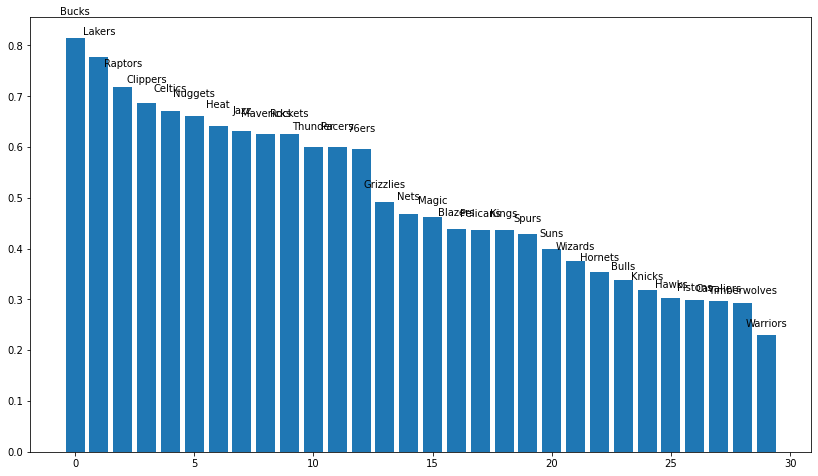

In [5]:
# 1st plot - original
fig, ax = plt.subplots(figsize = (14,8))
nickname = standings_df["Unnamed: 1"].apply(lambda x: x.split()[-1])
record = standings_df["Unnamed: 2"][1:].apply(lambda x: x.split("-")[0]).astype(int) / (standings_df["Unnamed: 2"][1:].apply(lambda x: x.split("-")[0]).astype(int) + standings_df["Unnamed: 2"][1:].apply(lambda x: x.split("-")[1]).astype(int))
x = list(range(30))
rects1 = ax.bar(x, record.sort_values(ascending = False))
def autolabel(rects):
    count = 1
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                nickname[count],
        ha='center', va='bottom')
        count = count + 1
autolabel(rects1)
ax.get_figure().savefig("fig1-before.svg", bbox_inches="tight")

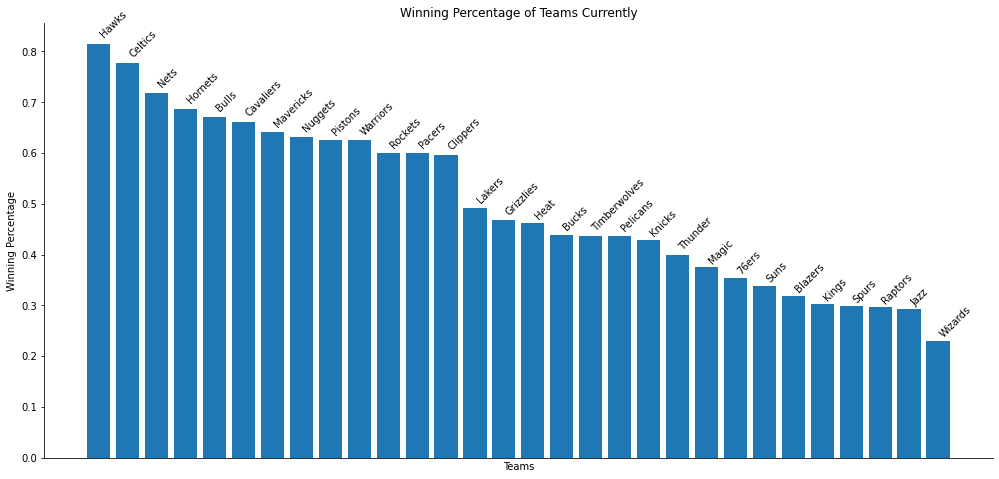

In [6]:
#1st plot - after feedback - no requiements fulfilled
fig, ax = plt.subplots(figsize = (17,8))
x = list(range(30))
rects1 = ax.bar(x, sort_standings["Win %"])
def autolabel(rects):
    count = 0
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, 1.01*height,
                sort_standings["Nickname"][count],
        ha='left', va='bottom', rotation = 45)
        count = count + 1
autolabel(rects1)
plt.xticks([],[])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Teams")
ax.set_ylabel("Winning Percentage")
ax.set_title("Winning Percentage of Teams Currently")

ax.get_figure().savefig("fig1.svg", bbox_inches="tight")

In [7]:
#cleaning
team_per_game_clean = team_per_game_df[:30]
team_per_game_clean = team_per_game_clean.sort_values(by = ["Team"], ignore_index = True)

opponents_per_game_clean = opponents_per_game_df[:30]
opponents_per_game_clean = opponents_per_game_clean.sort_values(by = ["Team"], ignore_index = True)

clean_df["Margin"] = team_per_game_clean["PTS"] - opponents_per_game_clean["PTS"]
cor = pearsonr(clean_df["Margin"], clean_df["Win %"])[0]
reg = lm.LinearRegression().fit(clean_df["Margin"].values.reshape(-1,1), clean_df["Win %"])

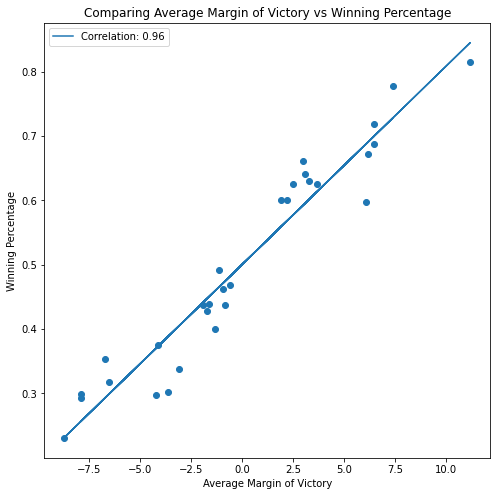

In [8]:
#2nd plot fufills the 3rd requirement
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(clean_df["Margin"], clean_df["Win %"])
line = reg.coef_[0] * clean_df["Margin"] + reg.intercept_
ax.plot(clean_df["Margin"], line, label = "Correlation: %.2f" %cor)
ax.set_xlabel("Average Margin of Victory")
ax.set_ylabel("Winning Percentage")
ax.set_title("Comparing Average Margin of Victory vs Winning Percentage")
ax.legend()

ax.get_figure().savefig("fig2.svg", bbox_inches="tight")

In [9]:
#cleaning
clean_df["Home Win %"] = standings_clean["Place"].apply(lambda x: x.split("-")[0]).astype(int) / (standings_clean["Place"].apply(lambda x: x.split("-")[0]).astype(int) + standings_clean["Place"].apply(lambda x: x.split("-")[1]).astype(int))
misc_clean = misc_df[1:31]
misc_clean = misc_clean.sort_values(by = ["Unnamed: 1"], ignore_index = True)
clean_df["Attend/G"] = misc_clean["Unnamed: 27"].astype(float)

cor = pearsonr(clean_df["Attend/G"], clean_df["Home Win %"])[0]
reg = lm.LinearRegression().fit(clean_df["Attend/G"].values.reshape(-1,1), clean_df["Home Win %"])



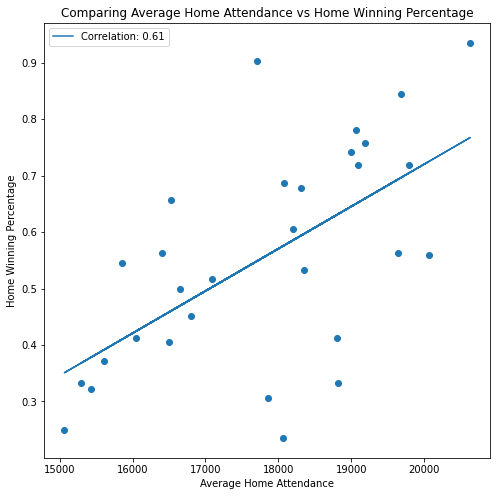

In [10]:
#Plot 3
#Little correlation so corona should affect all teams not having their normal amount of fans similiarlly
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(clean_df["Attend/G"], clean_df["Home Win %"])
line = reg.coef_[0] * clean_df["Attend/G"] + reg.intercept_
ax.plot(clean_df["Attend/G"], line, label = "Correlation: %.2f" %cor)
ax.set_xlabel("Average Home Attendance")
ax.set_ylabel("Home Winning Percentage")
ax.set_title("Comparing Average Home Attendance vs Home Winning Percentage")
ax.legend()


